# Importing Dependencies

In [1]:
!pip install ipython-autotime
%matplotlib inline
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-py3-none-any.whl size=1830 sha256=0159bfb587d80ce6530d7cf4b4f78bc4584d29b7ecad913609594d80f425f474
  Stored in directory: /root/.cache/pip/wheels/65/56/4a/4b967e4b9b62bd9d8d7ca789bba648c702d705487f28845bb2
Successfully built ipython-autotime
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np 
import pandas as pd 
import os,re
import unicodedata
import gc
import time

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy

from numba import jit, cuda

time: 10.3 s


# TPU configuration

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8
time: 3.14 s


# Reading Data

In [4]:
# the data paths
data_path = '/kaggle/input/jigsaw-multilingual-toxic-comment-classification/'
translated_data_path = '/kaggle/input/jigsaw-multilingual-toxic-test-translated/'

# loading all the train datasets

train_data1 = pd.read_csv(data_path + 'jigsaw-toxic-comment-train.csv')
# train_data2 = pd.read_csv(data_path + 'jigsaw-toxic-comment-train-processed-seqlen128.csv')
train_data3 = pd.read_csv(data_path + 'jigsaw-unintended-bias-train.csv')
# train_data4 = pd.read_csv(data_path + 'jigsaw-unintended-bias-train-processed-seqlen128.csv')

# loading all the validation and test datasets

# validation_data1 = pd.read_csv(data_path + 'validation.csv')
# validation_data2 = pd.read_csv(data_path + 'validation-processed-seqlen128.csv')
valid_translated = pd.read_csv(translated_data_path + 'jigsaw_miltilingual_valid_translated.csv')

# test_data1 = pd.read_csv(data_path + 'test.csv')
# test_data2 = pd.read_csv(data_path + 'test-processed-seqlen128.csv')
test_translated = pd.read_csv(translated_data_path + 'jigsaw_miltilingual_test_translated.csv')

time: 17.8 s


# Helper Functions

Text Cleaning Functions

In [5]:
# Stopword list
pattern = re.compile(r'\b('+r'|'.join(stopwords.words('english'))+r')\b\s*')

# @cuda.jit(device=True)
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

# @tf.function()
def clean_text(text):
    text = unicode_to_ascii(text.lower().strip())
    
    #replacing email addresses with blank space
    text = re.sub(r"[a-zA-Z0-9_\-\.]+@[a-zA-Z0-9_\-\.]+\.[a-zA-Z]{2,5}"," ",text)
    
    #replacing urls with blank space
    text = re.sub(r"\bhttp:\/\/([^\/]*)\/([^\s]*)|https:\/\/([^\/]*)\/([^\s]*)"," ",text)
    
    # creating a space between a word and the punctuation following it
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    
    # replacing all the stopwords
    text = pattern.sub('',text)
    
    # removes all the punctuations
    text = re.sub(r"[^a-zA-Z]+", " ", text)
    
    text = text.strip()

    # adding a start and an end token to the sentence so that the model know when to start and stop predicting.
#     text = '<start> ' + text + ' <end>'
    
    return text

clean_text_vect = np.vectorize(clean_text)

time: 20.2 ms


In [6]:
def chunk_clean(array,chunk_size=256):
    cleaned_array = []
    
    for i in tqdm(range(0, len(array), chunk_size)):
        text_chunk = clean_text_vect(array[i:i+chunk_size])
        cleaned_array.extend(text_chunk)

    return np.array(cleaned_array)

time: 1.45 ms


Tokenizing and Encoding Functions

In [7]:
def regular_encode(texts, tokenizer, maxlen=512):
    tokenizer.pad_token = tokenizer.pad_token
    tokenizer.unk_token = tokenizer.unk_token
    
    enc_di = tokenizer.batch_encode_plus(
        list(texts), 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen,
    )
    
    return np.array(enc_di['input_ids'])

time: 1.53 ms


In [8]:
def chunk_encode(texts,tokenizer,maxlen=512,chunk_size=256):
    all_enc=[]
    for i in tqdm(range(0,len(texts),chunk_size)):
        enc = list(regular_encode(texts[i:i+chunk_size],tokenizer,maxlen=maxlen))
        all_enc.extend(enc)
        
    return np.array(all_enc)

time: 1.69 ms


In [9]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

time: 2.34 ms


# Tokenizer

In [10]:
MODEL3 = 'jplu/tf-xlm-roberta-large'

time: 493 µs


In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL3)
print(tokenizer.save_pretrained('.'))
print(tokenizer)


('./sentencepiece.bpe.model', './special_tokens_map.json', './added_tokens.json')
time: 2.44 s


In [12]:
# tokenizer = transformers.BertTokenizerFast.from_pretrained('bert-large-uncased')
# tokenizer.save_pretrained('.')
# fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
# fast_tokenizer

time: 385 µs


# Data Preparation

Data Splitting

In [13]:
train_data3.toxic = train_data3.toxic.round().astype(int)
# valid_translated['comment_text'] = valid_translated['translated']

data = pd.concat([
    train_data1[['comment_text', 'toxic']],
    train_data3[['comment_text', 'toxic']].query('toxic==1'),
    train_data3[['comment_text', 'toxic']].query('toxic==0').sample(n=200000, random_state=0),
    valid_translated[['comment_text','toxic']]
])
data.toxic = data.toxic.round().astype(int)

final_test_data = test_translated.content.values

print('Number of toxic comments = ',list(data.toxic).count(1))
print('Number of non-toxic comments = ',list(data.toxic).count(0))

Number of toxic comments =  134840
Number of non-toxic comments =  408935
time: 947 ms


In [14]:
# np.random.seed(2048)
# train, valid, test = np.split(data.sample(frac=1), [int(.8*len(data)), int(.9*len(data))])
train, valid = np.split(data.sample(frac=1), [int(.8*len(data))])

print("Train rows = ", train.shape[0])
print("validate rows = ", valid.shape[0])
# print("Test rows = ", test.shape[0])
print("\nFinal Test Data rows = ",len(final_test_data))

Train rows =  435020
validate rows =  108755

Final Test Data rows =  63812
time: 143 ms


In [15]:
del train_data1
del train_data3
del valid_translated
del data
gc.collect()

85

time: 382 ms


Cleaning and Encoding

In [16]:
x_train = chunk_clean(train.comment_text.values)
x_valid = chunk_clean(valid.comment_text.values)
# x_test = chunk_clean(test.comment_text.values)

final_test_data = chunk_clean(final_test_data)


time: 4min 5s


In [17]:
MAX_LEN =128

time: 796 µs


In [18]:
x_train=chunk_encode(x_train, tokenizer, maxlen=MAX_LEN)
x_valid=chunk_encode(x_valid, tokenizer, maxlen=MAX_LEN)
# x_test=chunk_encode(x_test, tokenizer, maxlen=MAX_LEN)

final_test_data = chunk_encode(final_test_data, tokenizer, maxlen=MAX_LEN)


time: 4min 33s


In [19]:
# x_train=fast_encode(x_train, fast_tokenizer, maxlen=MAX_LEN)
# x_valid=fast_encode(x_valid, fast_tokenizer, maxlen=MAX_LEN)
# x_test=fast_encode(x_test, fast_tokenizer, maxlen=MAX_LEN)
# final_test_data = fast_encode(final_test_data, fast_tokenizer, maxlen=MAX_LEN)

time: 403 µs


In [20]:
y_train = np.array(train.toxic.values)
y_train.resize((len(y_train),1))

y_valid = np.array(valid.toxic.values)
y_valid.resize((len(y_valid),1))

# y_test = np.array(test.toxic.values)
# y_test.resize((len(y_test),1))

time: 3 ms


In [21]:
print('Comment_text shapes\n')
print('x_train shape = ',x_train.shape)
print('x_valid shape = ',x_valid.shape)
# print('x_test shape = ',x_test.shape)
print('-'*35)
print('Labels shapes\n')
print('y_train shape = ',y_train.shape)
print('y_valid shape = ',y_valid.shape)
# print('y_test shape = ',y_test.shape)
print('-'*35)
print("Shape of final_test_data = ", final_test_data.shape)

Comment_text shapes

x_train shape =  (435020, 128)
x_valid shape =  (108755, 128)
-----------------------------------
Labels shapes

y_train shape =  (435020, 1)
y_valid shape =  (108755, 1)
-----------------------------------
Shape of final_test_data =  (63812, 128)
time: 2.19 ms


# Converting Data to Tensors

In [22]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

time: 715 µs


In [23]:
train = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .repeat()
    .shuffle(512)
    .prefetch(AUTO)
)

# test = (
#     tf.data.Dataset
#     .from_tensor_slices((x_test,y_test))
#     .batch(BATCH_SIZE)
#     .cache()
#     .prefetch(AUTO)
# )

final_test_data = (
    tf.data.Dataset
    .from_tensor_slices(final_test_data)
    .batch(BATCH_SIZE)
)

time: 2.53 s


# Building the Model

In [24]:
EPOCHS = 2

time: 584 µs


In [25]:
def build_model(transformer, max_len=512):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    
    out = Dense(32,activation=tf.nn.swish)(cls_token)
    out = Dense(16,activation=tf.nn.swish)(out)
    out = Dense(1, activation='sigmoid')(out)
    
    model = Model(inputs=input_word_ids, outputs=out)
    
    model.compile(Adam(lr=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

time: 2.77 ms


In [26]:
with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL3)
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 128)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 128, 1024), (None 559890432 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 32)                32800     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 559,923,777
Trainable params: 559,923,777
Non-trainable params: 0
______________________________________________

# Training the Model

Stage 1

In [27]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train,
    steps_per_epoch=n_steps,
    validation_data=valid,
    validation_steps=128,
    epochs=EPOCHS
)

Train for 3398 steps, validate for 128 steps
Epoch 1/2


/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)
/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


3398/3398 [==============================] - 1398s 411ms/step - loss: 0.2128 - accuracy: 0.9101 - val_loss: 0.1879 - val_accuracy: 0.9199
Epoch 2/2
3398/3398 [==============================] - 1214s 357ms/step - loss: 0.1748 - accuracy: 0.9266 - val_loss: 0.1869 - val_accuracy: 0.9236
time: 43min 31s


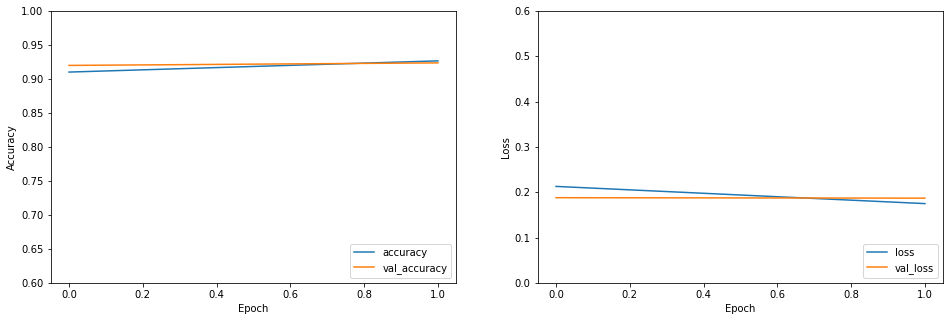

time: 531 ms


In [28]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 5))

plt.subplot(1,2,1)
plt.plot(epochs_range,train_history.history['accuracy'], label='accuracy')
plt.plot(epochs_range,train_history.history['val_accuracy'], label = 'val_accuracy')
plt.ylim(0.6,1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(epochs_range,train_history.history['loss'], label='loss')
plt.plot(epochs_range,train_history.history['val_loss'], label = 'val_loss')
plt.ylim(0,0.6)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [29]:
sub = pd.read_csv(data_path + 'sample_submission.csv')
sub['toxic'] = model.predict(final_test_data, verbose=1)
sub.to_csv('submission.csv', index=False)

499/499 [==============================] - 89s 178ms/step
time: 1min 29s


Stage 2

In [30]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid.repeat(),
    steps_per_epoch=n_steps,
    epochs=4
)

Train for 849 steps
Epoch 1/4


/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


849/849 [==============================] - 468s 552ms/step - loss: 0.1759 - accuracy: 0.9265
Epoch 2/4
849/849 [==============================] - 301s 354ms/step - loss: 0.1551 - accuracy: 0.9363
Epoch 3/4
849/849 [==============================] - 301s 355ms/step - loss: 0.1335 - accuracy: 0.9456
Epoch 4/4
849/849 [==============================] - 301s 354ms/step - loss: 0.1119 - accuracy: 0.9546
time: 22min 51s


**Evaluating the Model**

In [31]:
loss,accuracy = model.evaluate(valid,verbose=1)
print('Accuracy = ',accuracy)

ValueError: When passing an infinitely repeating dataset, you must specify the `steps` argument.

time: 630 ms


# Prediction using the Model

In [32]:
sub1 = pd.read_csv(data_path + 'sample_submission.csv')
sub1['toxic'] = model.predict(final_test_data, verbose=1)
sub1.to_csv('submission.csv', index=False)

499/499 [==============================] - 81s 162ms/step
time: 1min 21s
